This case study will explore the examples of Wassmer and Dragalin (2015). This paper uses closed testing methods to ensure Type I Error control, while adapting the trial to focus patient recruitment on the subpopulations where the treatment performs best.

There are 3 different case studies in the paper: 4.1, 4.2, and 4.3.
4.1 uses binomial outcomes, with a Bonferroni rule, with 2 total subgroups x 2 treatments (T vs C) = 4 parameters. Two analysis times, including the final. This should be improvable.
4.2 uses exponential outcomes, does a log-rank test with Dunnett's test for multiple comparisons, with 2 total subgroups x 2 treatments = with 2 total subgroups x 2 treatments (T vs C) = 4 parameters. Four analysis times, including the final. We expect that this one is essentially tight/hard to improve, because it uses Dunnett, which should be tight
4.3 uses exponential outcomes, and does log-rank tests with the Bonferroni rule, with 4 subgroups x 2 treatments = 8 parameters. This is too much for proof-by-simulation to cover. We could still give a superior power analysis to what was reported in the paper, which fixes many of these parameters and varies the treatment effects.

Of this subset, WE WILL DO: 4.1, and then show that it can also be done under exponential outcomes, in both cases yielding improvements.

If we want to beef it up further we could try to compare against 4.2


In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imprint as ip
import numpy as np
import math
import random
import jax
import jax.numpy as jnp
from scipy.special import expit, logit
from jax.config import config

config.update("jax_enable_x64", True)

First, we will replicate example 4.1
The population breakdown is 54% HRplus, 46% no-HRplus. [Let's assumed blocked sample sizes, for simplicity; and note that this anyway describes how the problem would be approached with post-conditioning]

The null hypotheses here are:
(1) HRplus > 0.34
(2) 0.54 p_HRplus + 0.46 p_HER+ > 0.54 _ 0.34 + 0.46 _ 0.23

A decision will be made after 150 patients. There is no early-stopping, but the trial can either select the HRplus group, or continue to the final analysis. This selection occurs if the estimated effect size of HRplus = p-hat_HRplus - 0.34 > epsilon + p-hat_average - (0.34*.54 + 0.23*0.46)
where epsilon = 10%

If the HER+ group is dropped, then its p-value automatically jumps to 1 and stays there(cannot-reject) but it is still present for the closed test.

The p-values for the closed test are determined by inference on the binomial using the z-approximation with pooling treatment and control:

Z = pi-hat_1 - pi-hat_0 /sqrt(pi-hat-combined _ (1 - pi-hat-combined)_(1/n_1 + 1/n_2))

We will do closed testing on the p-values from these two z-statistics.


In [2]:
# Let's make some sub-methods, to perform the methods given one binomial setting
pcontrol_TNBC = 0.34
ptreat_TNBC = 0.38
pcontrol_HRplus = 0.23
ptreat_HRplus = 0.27

# TODO: effect size is 0.04 so we are in alternative space for both hypotheses.
# null hypo 1: effect size of tnbc = 0
# null hypo 2: effect size of weighted average of tnbc and hrplus = 0
#

# generate hypotheses: for this, we have to do stuff similar to the closedtesting.pynb
# There will be 2 hypotheses, one of which will have to be identified with a nonlinear equation in theta-space
# Let's leave that to Ben, and just focus on executing the design

## Things to improve here:

- constructing null hypothesis boundaries for imprint: ask mike
- run imprint
- make it fast/jax-ify
- compare against a simple t-test with the same simulation/model.
  

In [3]:
n_requested_first_stage = 150
n_requested_second_stage = 150
frac_tnbc = 0.54

def split(n_stage):
    return (
        int(np.floor((n_stage * frac_tnbc) * 0.5)),
        int(np.floor(n_stage * (1 - frac_tnbc) * 0.5)),
    )

n_TNBC_first_stage_per_arm, n_HRplus_first_stage_per_arm = split(n_requested_first_stage)
n_TNBC_first_stage_total = n_TNBC_first_stage_per_arm * 2
n_HRplus_first_stage_total = n_HRplus_first_stage_per_arm * 2
n_first_stage = n_TNBC_first_stage_total + n_HRplus_first_stage_total
print(n_TNBC_first_stage_per_arm, n_HRplus_first_stage_per_arm, n_first_stage)

n_TNBC_second_stage_per_arm, n_HRplus_second_stage_per_arm = split(n_requested_second_stage)
n_TNBC_second_stage_total = n_TNBC_second_stage_per_arm * 2
n_HRplus_second_stage_total = n_HRplus_second_stage_per_arm * 2
n_second_stage = n_TNBC_second_stage_total + n_HRplus_second_stage_total
print(n_TNBC_second_stage_per_arm, n_HRplus_second_stage_per_arm, n_second_stage)

40 34 148
40 34 148


In [49]:
def sim(i, pcontrol_TNBC=0.34, ptreat_TNBC=0.38, pcontrol_HRplus=0.23, ptreat_HRplus=0.27):
    # We now have to make a list of the relevant
    # intersection hypotheses,
    # which are indentified by which subgroups are part of them
    # In this example, there are 2 elementary hypotheses
    hypoTNBC_live = True
    hypofull_live = True
    # There is also the intersection hypothesis:
    # hypo_both_live

    unifsTNBCcontrol = np.random.uniform(size=n_TNBC_first_stage_per_arm)
    unifsTNBCtreat = np.random.uniform(size=n_TNBC_first_stage_per_arm)
    unifsHRpluscontrol = np.random.uniform(size=n_HRplus_first_stage_per_arm)
    unifsHRplustreat = np.random.uniform(size=n_HRplus_first_stage_per_arm)
    # TODO: mean here
    outcomesHRpluscontrol = unifsHRpluscontrol < pcontrol_HRplus
    outcomesHRplustreat = unifsHRplustreat < ptreat_HRplus
    outcomesTNBCcontrol = unifsTNBCcontrol < pcontrol_TNBC
    outcomesTNBCtreat = unifsTNBCtreat < ptreat_TNBC

    # Note: this could be expressed more simply as a single function if we could nicely combine treatment outcome columns. but whatever...
    TNBC_pooledaverage = outcomesTNBCtreat.mean() / 2 + outcomesTNBCcontrol.mean() / 2
    denominatorTNBC = np.sqrt(
        TNBC_pooledaverage
        * (1 - TNBC_pooledaverage)
        * (2 / n_TNBC_first_stage_per_arm)
    )
    zTNBC_stage1 = (
        outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
    ) / denominatorTNBC

    totally_pooledaverage = (
        outcomesTNBCtreat.mean() * n_TNBC_first_stage_per_arm / n_first_stage
        + outcomesTNBCcontrol.mean() * n_TNBC_first_stage_per_arm / n_first_stage
        + outcomesHRplustreat.mean() * n_HRplus_first_stage_per_arm / n_first_stage
        + outcomesHRpluscontrol.mean() * n_HRplus_first_stage_per_arm / n_first_stage
    )
    denominatortotallypooled = np.sqrt(
        totally_pooledaverage
        * (1 - totally_pooledaverage)
        * (2 / (n_TNBC_first_stage_per_arm + n_HRplus_first_stage_per_arm))
    )
    tnbc_effect = outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
    hrplus_effect = outcomesHRplustreat.mean() - outcomesHRpluscontrol.mean()
    zfull_stage1 = (
        (tnbc_effect * n_TNBC_first_stage_total / n_first_stage)
        + (hrplus_effect * n_HRplus_first_stage_total / n_first_stage)
    ) / denominatortotallypooled

    # Arm-dropping logic: drop all elementary hypotheses with larger than 0.1 difference in effect size
    effectsize_difference = tnbc_effect - hrplus_effect
    # TODO: investigate this dropping logic. Section 3.4, ctrl-f "epsilon"
    # TODO: this is wrong and should be compared to the weighted average
    # treatment effects instead of the HRplus treatment effect.
    if effectsize_difference > 0.1:
        hypofull_live = False
    if effectsize_difference < -0.1:
        hypoTNBC_live = False

    # now compute second-stage z-statistics
    if not hypofull_live:  # In this case we drop the HRplus arm
        # Here, we ignored n_HRplus_second_stage_per_arm patients because the
        # HRplus arm has been dropped.
        npatientsperarm_secondstage = n_second_stage // 2
        unifsTNBCcontrol = np.random.uniform(size=npatientsperarm_secondstage)
        unifsTNBCtreat = np.random.uniform(size=npatientsperarm_secondstage)
        outcomesTNBCcontrol = unifsTNBCcontrol < pcontrol_TNBC
        outcomesTNBCtreat = unifsTNBCtreat < ptreat_TNBC
        TNBC_pooledaverage = (
            outcomesTNBCtreat.mean() / 2 + outcomesTNBCcontrol.mean() / 2
        )
        denominatorTNBC = np.sqrt(
            TNBC_pooledaverage
            * (1 - TNBC_pooledaverage)
            * (2 / npatientsperarm_secondstage)
        )
        zTNBC_stage2 = (
            outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
        ) / denominatorTNBC
        zfull_stage2 = -np.inf
    else:
        unifsTNBCcontrol = np.random.uniform(size=n_TNBC_second_stage_per_arm)
        unifsTNBCtreat = np.random.uniform(size=n_TNBC_second_stage_per_arm)
        unifsHRpluscontrol = np.random.uniform(size=n_HRplus_second_stage_per_arm)
        unifsHRplustreat = np.random.uniform(size=n_HRplus_second_stage_per_arm)
        outcomesHRpluscontrol = unifsHRpluscontrol < pcontrol_HRplus
        outcomesHRplustreat = unifsHRplustreat < ptreat_HRplus
        outcomesTNBCcontrol = unifsTNBCcontrol < pcontrol_TNBC
        outcomesTNBCtreat = unifsTNBCtreat < ptreat_TNBC
        TNBC_pooledaverage = (
            outcomesTNBCtreat.mean() / 2 + outcomesTNBCcontrol.mean() / 2
        )
        denominatorTNBC = np.sqrt(
            TNBC_pooledaverage
            * (1 - TNBC_pooledaverage)
            * (2 / n_TNBC_second_stage_per_arm)
        )
        zTNBC_stage2 = (
            outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
        ) / denominatorTNBC

        totally_pooledaverage = (
            outcomesTNBCtreat.mean() * n_TNBC_second_stage_per_arm / n_second_stage
            + outcomesTNBCcontrol.mean() * n_TNBC_second_stage_per_arm / n_second_stage
            + outcomesHRplustreat.mean() * n_HRplus_second_stage_per_arm / n_second_stage
            + outcomesHRpluscontrol.mean() * n_HRplus_second_stage_per_arm / n_second_stage
        )
        denominatortotallypooled = np.sqrt(
            totally_pooledaverage
            * (1 - totally_pooledaverage)
            * (2 / (n_TNBC_first_stage_per_arm + n_HRplus_first_stage_per_arm))
        )
        tnbc_effect = outcomesTNBCtreat.mean() - outcomesTNBCcontrol.mean()
        hrplus_effect = outcomesHRplustreat.mean() - outcomesHRpluscontrol.mean()
        zfull_stage2 = (
            (tnbc_effect * n_TNBC_second_stage_total / n_second_stage)
            + (hrplus_effect * n_HRplus_second_stage_total / n_second_stage)
        ) / denominatortotallypooled

    # now combine test statistics
    # Now we go through the 3 intersection tests:
    hypTNBC_zstat = zTNBC_stage1 / np.sqrt(2) + zTNBC_stage2 / np.sqrt(2)
    hypfull_zstat = zfull_stage1 / np.sqrt(2) + zfull_stage2 / np.sqrt(2)

    # Now doing the combination rule for the intersection test
    # we multiply the p-value by two by analogy to bonferroni
    HI_pfirst = 2 * (1 - scipy.stats.norm.cdf(max(zTNBC_stage1, zfull_stage1)))
    HI_zfirst = scipy.stats.norm.ppf(1 - HI_pfirst)
    HI_zsecond = (
        hypofull_live
        * hypoTNBC_live
        * scipy.stats.norm.ppf(
            1 - 2 * (1 - scipy.stats.norm.cdf(max(zTNBC_stage2, zfull_stage2)))
        )
    )
    HI_zsecond += (not hypofull_live) * hypoTNBC_live * zTNBC_stage2
    HI_zsecond += (
        hypofull_live
        * (not hypoTNBC_live)
        * np.nan_to_num(zfull_stage2, posinf=0, neginf=0)
    )

    HI_zcombined = HI_zfirst / np.sqrt(2) + HI_zsecond / np.sqrt(2)

    # Now we resolve which elementary statistics actually reject the null hypothesis
    rejectintersection = HI_zcombined > 1.96
    rejectTNBC_elementary = hypTNBC_zstat > 1.96
    rejectfull_elementary = hypfull_zstat > 1.96

    rejectTNBC_final = (
        rejectTNBC_elementary & rejectintersection
    )  # we use this for actual hypothesis rejections!
    rejectfull_final = (
        rejectfull_elementary & rejectintersection
    )  # we use this for actual hypothesis rejections!
    return dict(
        hypoTNBC_live=hypoTNBC_live,
        hypofull_live=hypofull_live,
        rejectTNBC_final=rejectTNBC_final,
        rejectfull_final=rejectfull_final,
        zTNBC_stage1=zTNBC_stage1,
        zTNBC_stage2=zTNBC_stage2,
        zfull_stage1=zfull_stage1,
        zfull_stage2=zfull_stage2,
        HI_pfirst=HI_pfirst,
        HI_zfirst=HI_zfirst,
        HI_zsecond=HI_zsecond,
        HI_zcombined=HI_zcombined,
    )

np.random.seed(0)
# results = pd.DataFrame([sim(ptreat_TNBC=0.44, ptreat_HRplus=0.33) for i in range(500)])

results = pd.DataFrame([sim(i, ptreat_TNBC=0.44, ptreat_HRplus=0.33) for i in range(500)])

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_5761/3494094746.py:130: RuntimeWarning: invalid value encountered in scalar multiply
  hypofull_live


In [50]:
print(results.mean())
print('\nstd dev')
print(results.std())

hypoTNBC_live       0.728000
hypofull_live       0.742000
rejectTNBC_final    0.236000
rejectfull_final    0.220000
zTNBC_stage1        0.979078
zTNBC_stage2        0.966634
zfull_stage1        1.361339
zfull_stage2            -inf
HI_pfirst           0.283411
HI_zfirst               -inf
HI_zsecond              -inf
HI_zcombined            -inf
dtype: float64

std dev
hypoTNBC_live       0.445436
hypofull_live       0.437972
rejectTNBC_final    0.425047
rejectfull_final    0.414661
zTNBC_stage1        1.016155
zTNBC_stage2        0.968854
zfull_stage1        0.985513
zfull_stage2             NaN
HI_pfirst           0.364267
HI_zfirst                NaN
HI_zsecond               NaN
HI_zcombined             NaN
dtype: float64


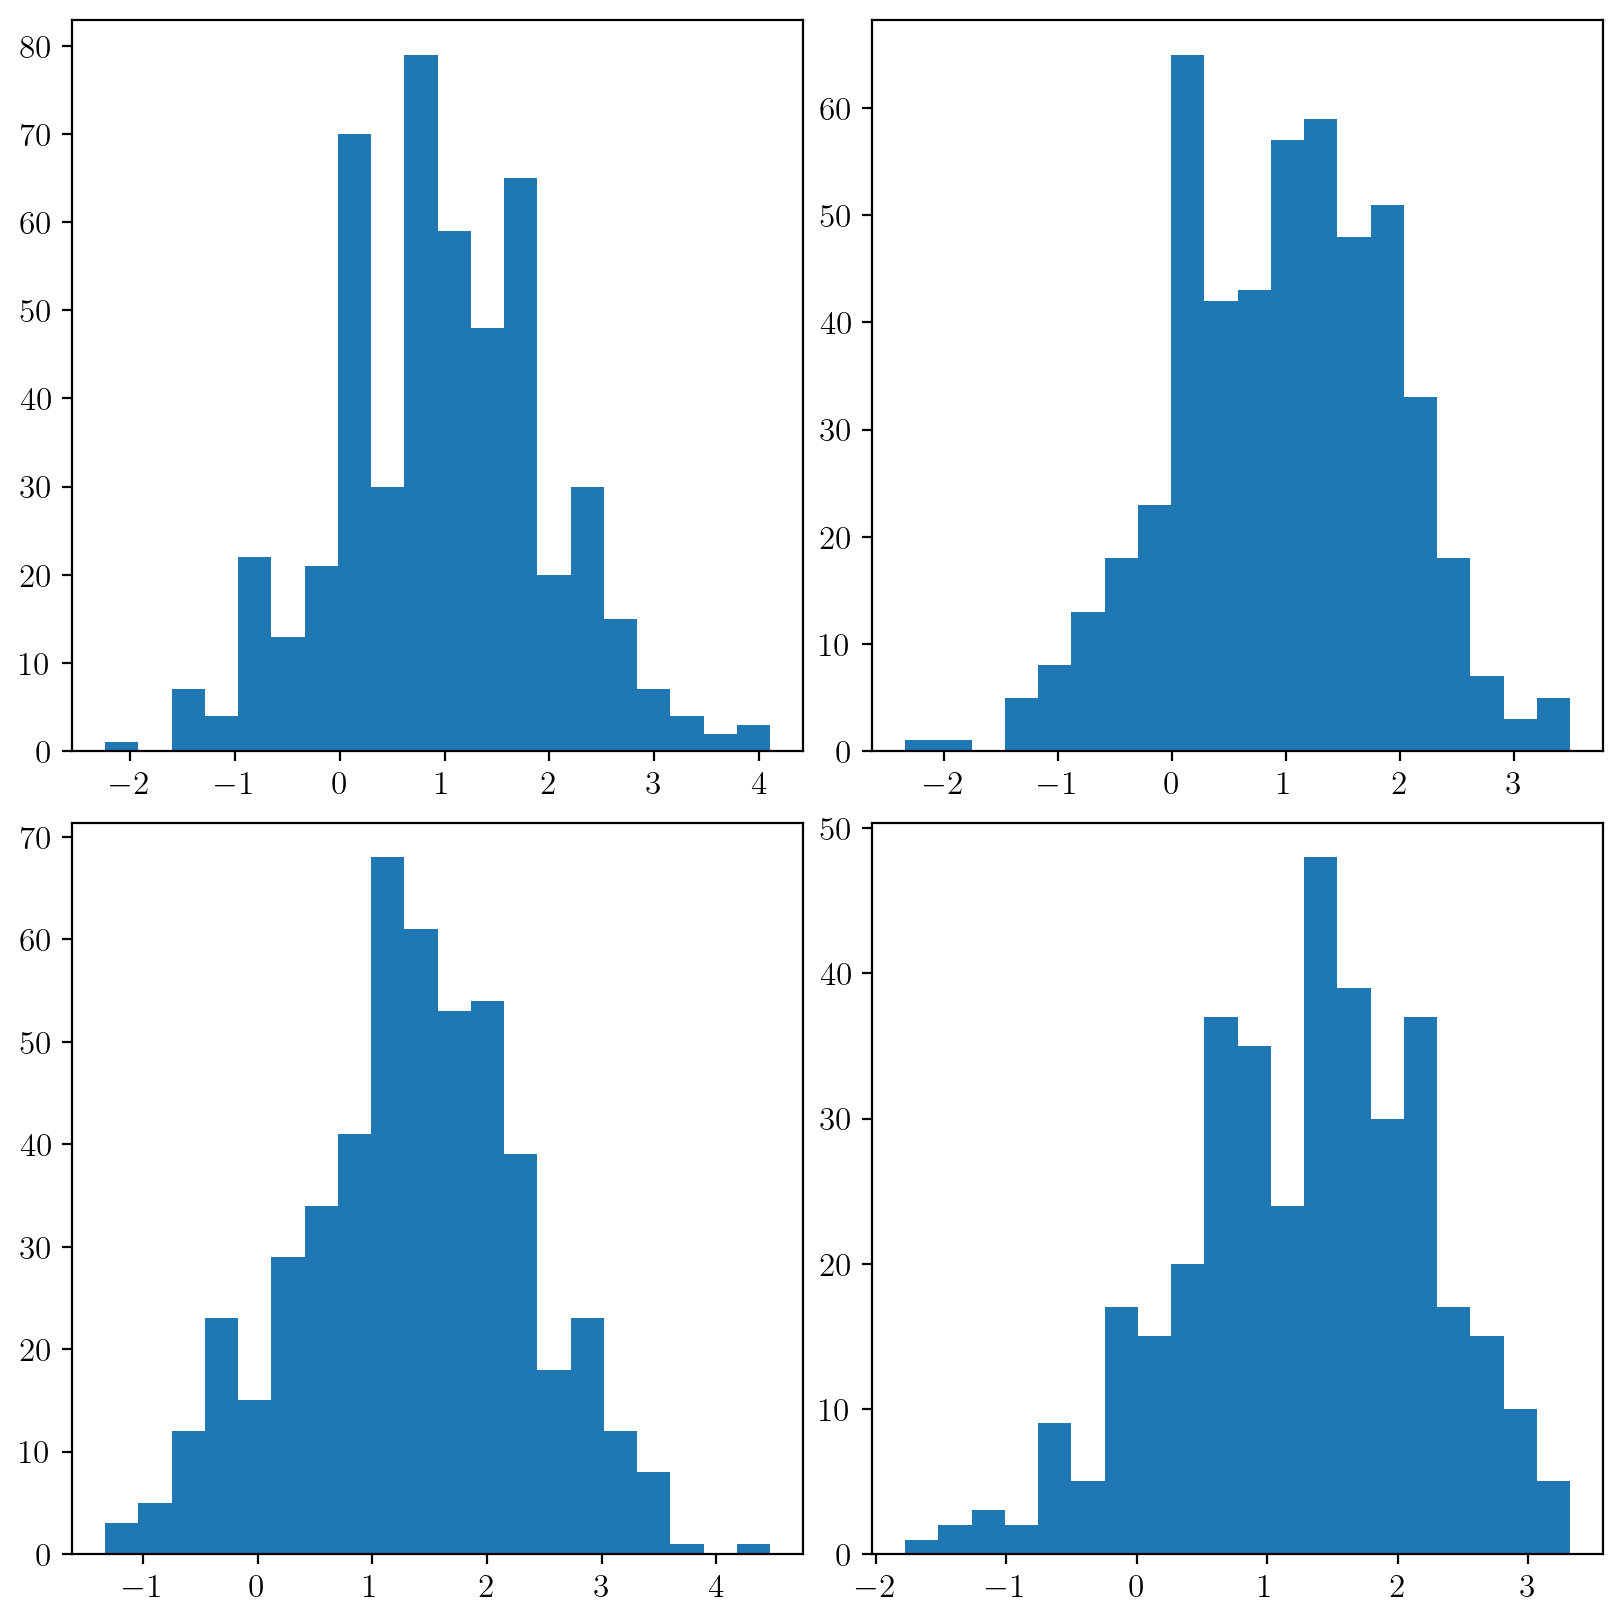

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8), constrained_layout=True)
plt.subplot(2, 2, 1)
plt.hist(results["zTNBC_stage1"], bins=20)
plt.subplot(2, 2, 2)
plt.hist(results["zTNBC_stage2"], bins=20)
plt.subplot(2, 2, 3)
plt.hist(results["zfull_stage1"], bins=20)
plt.subplot(2, 2, 4)
plt.hist(results["zfull_stage2"].replace(-np.inf, np.nan).dropna(), bins=20)
plt.show()

## Make it clean and fast, phase 1

In [52]:
def zTNBC(phatTNBCcontrol, phatTNBCtreat, n_per_arm):
    TNBC_pooledaverage = (phatTNBCtreat + phatTNBCcontrol) / 2
    denominatorTNBC = jnp.sqrt(
        TNBC_pooledaverage * (1 - TNBC_pooledaverage) * (2 / n_per_arm)
    )
    return (phatTNBCtreat - phatTNBCcontrol) / denominatorTNBC


def zfull(phatTNBCcontrol, phatTNBCtreat, phatHRpluscontrol, phatHRplustreat):
    totally_pooledaverage = (
        phatTNBCtreat + phatTNBCcontrol
    ) * n_TNBC_first_stage_per_arm / n_first_stage + (
        phatHRplustreat + phatHRpluscontrol
    ) * n_HRplus_first_stage_per_arm / n_first_stage
    denominatortotallypooled = jnp.sqrt(
        totally_pooledaverage
        * (1 - totally_pooledaverage)
        * (2 / (n_TNBC_first_stage_per_arm + n_HRplus_first_stage_per_arm))
    )
    tnbc_effect = phatTNBCtreat - phatTNBCcontrol
    hrplus_effect = phatHRplustreat - phatHRpluscontrol
    return (
        (tnbc_effect * n_TNBC_first_stage_total / n_first_stage)
        + (hrplus_effect * n_HRplus_first_stage_total / n_first_stage)
    ) / denominatortotallypooled


def sample(unifs, next_idx, n, p):
    return next_idx + n, jnp.mean(unifs[next_idx : next_idx + n] < p, dtype=unifs.dtype)

@jax.jit
def stage1(unifs, pcontrol_TNBC, ptreat_TNBC, pcontrol_HRplus, ptreat_HRplus):
    next_idx, phatTNBCcontrol = sample(unifs, 0, n_TNBC_first_stage_per_arm, pcontrol_TNBC)
    next_idx, phatTNBCtreat = sample(unifs, next_idx, n_TNBC_first_stage_per_arm, ptreat_TNBC)
    next_idx, phatHRpluscontrol = sample(unifs,
        next_idx, n_HRplus_first_stage_per_arm, pcontrol_HRplus
    )
    next_idx, phatHRplustreat = sample(unifs,
        next_idx, n_HRplus_first_stage_per_arm, ptreat_HRplus
    )

    # Arm-dropping logic: drop all elementary hypotheses with larger than 0.1 difference in effect size
    tnbc_effect = phatTNBCtreat - phatTNBCcontrol
    hrplus_effect = phatHRplustreat - phatHRpluscontrol
    effectsize_difference = tnbc_effect - hrplus_effect
    # TODO: investigate this dropping logic. Section 3.4, ctrl-f "epsilon"
    # TODO: this is wrong and should be compared to the weighted average
    # treatment effects instead of the HRplus treatment effect??
    hypofull_live = effectsize_difference <= 0.1
    hypoTNBC_live = effectsize_difference >= -0.1

    return (
        next_idx,
        zTNBC(phatTNBCcontrol, phatTNBCtreat, n_TNBC_first_stage_per_arm),
        zfull(phatTNBCcontrol, phatTNBCtreat, phatHRpluscontrol, phatHRplustreat),
        phatTNBCcontrol,
        phatTNBCtreat,
        phatHRpluscontrol,
        phatHRplustreat,
        effectsize_difference,
        hypofull_live,
        hypoTNBC_live,
    )

In [55]:

def sim(
    unifs,
    pcontrol_TNBC=0.34,
    ptreat_TNBC=0.38,
    pcontrol_HRplus=0.23,
    ptreat_HRplus=0.27,
):
    # We now have to make a list of the relevant
    # intersection hypotheses,
    # which are indentified by which subgroups are part of them
    # In this example, there are 2 elementary hypotheses
    # hypoTNBC_live = True
    # hypofull_live = True
    # There is also the intersection hypothesis:
    # hypo_both_live

    next_idx, zTNBC_stage1, zfull_stage1, phatTNBCcontrol, phatTNBCtreat, phatHRpluscontrol, phatHRplustreat, effectsize_difference, hypofull_live, hypoTNBC_live = stage1(
        unifs, pcontrol_TNBC, ptreat_TNBC, pcontrol_HRplus, ptreat_HRplus
    )

    # now compute second-stage z-statistics
    if not hypofull_live:  # In this case we drop the HRplus arm
        # Here, we ignored n_HRplus_second_stage_per_arm patients because the
        # HRplus arm has been dropped.
        npatientsperarm_secondstage = n_second_stage // 2
        next_idx, phatTNBCcontrol = sample(unifs,
            next_idx, npatientsperarm_secondstage, pcontrol_TNBC
        )
        next_idx, phatTNBCtreat = sample(unifs,
            next_idx, npatientsperarm_secondstage, ptreat_TNBC
        )
        zTNBC_stage2 = zTNBC(
            phatTNBCcontrol, phatTNBCtreat, npatientsperarm_secondstage
        )
        zfull_stage2 = -np.inf
    else:
        next_idx, phatTNBCcontrol = sample(unifs,
            next_idx, n_TNBC_second_stage_per_arm, pcontrol_TNBC
        )
        next_idx, phatTNBCtreat = sample(unifs,
            next_idx, n_TNBC_second_stage_per_arm, ptreat_TNBC
        )
        next_idx, phatHRpluscontrol = sample(unifs,
            next_idx, n_HRplus_second_stage_per_arm, pcontrol_HRplus
        )
        next_idx, phatHRplustreat = sample(unifs,
            next_idx, n_HRplus_second_stage_per_arm, ptreat_HRplus
        )
        zTNBC_stage2 = zTNBC(
            phatTNBCcontrol, phatTNBCtreat, n_TNBC_second_stage_per_arm
        )
        zfull_stage2 = zfull(
            phatTNBCcontrol, phatTNBCtreat, phatHRpluscontrol, phatHRplustreat
        )

    # now combine test statistics
    # Now we go through the 3 intersection tests:
    hypTNBC_zstat = zTNBC_stage1 / np.sqrt(2) + zTNBC_stage2 / np.sqrt(2)
    hypfull_zstat = zfull_stage1 / np.sqrt(2) + zfull_stage2 / np.sqrt(2)

    # Now doing the combination rule for the intersection test
    # we multiply the p-value by two by analogy to bonferroni
    HI_pfirst = 2 * (1 - scipy.stats.norm.cdf(max(zTNBC_stage1, zfull_stage1)))
    HI_zfirst = scipy.stats.norm.ppf(1 - HI_pfirst)
    HI_zsecond = np.where(
        hypofull_live and hypoTNBC_live,
        (
            scipy.stats.norm.ppf(
                1 - 2 * (1 - scipy.stats.norm.cdf(max(zTNBC_stage2, zfull_stage2)))
            )
        ),
        np.where(hypoTNBC_live, zTNBC_stage2, zfull_stage2)
    )

    HI_zcombined = HI_zfirst / np.sqrt(2) + HI_zsecond / np.sqrt(2)

    # Now we resolve which elementary statistics actually reject the null hypothesis
    rejectintersection = HI_zcombined > 1.96
    rejectTNBC_elementary = hypTNBC_zstat > 1.96
    rejectfull_elementary = hypfull_zstat > 1.96

    rejectTNBC_final = (
        rejectTNBC_elementary & rejectintersection
    )  # we use this for actual hypothesis rejections!
    rejectfull_final = (
        rejectfull_elementary & rejectintersection
    )  # we use this for actual hypothesis rejections!
    return dict(
        hypoTNBC_live=bool(hypoTNBC_live),
        hypofull_live=bool(hypofull_live),
        rejectTNBC_final=bool(rejectTNBC_final),
        rejectfull_final=bool(rejectfull_final),
        zTNBC_stage1=float(zTNBC_stage1),
        zTNBC_stage2=float(zTNBC_stage2),
        zfull_stage1=float(zfull_stage1),
        zfull_stage2=float(zfull_stage2),
        HI_pfirst=float(HI_pfirst),
        HI_zfirst=float(HI_zfirst),
        HI_zsecond=float(HI_zsecond),
        HI_zcombined=float(HI_zcombined),
    )


np.random.seed(0)
N = 500
unifs = np.random.uniform(size=(N, n_first_stage + n_second_stage)).astype(np.float64)
new_results = pd.DataFrame(
    [sim(unifs[i], ptreat_TNBC=0.44, ptreat_HRplus=0.33) for i in range(N)]
)


In [59]:
results.iloc[310]

hypoTNBC_live           True
hypofull_live          False
rejectTNBC_final       False
rejectfull_final       False
zTNBC_stage1        3.595733
zTNBC_stage2       -0.347586
zfull_stage1        3.525568
zfull_stage2            -inf
HI_pfirst           0.000323
HI_zfirst           3.411123
HI_zsecond               NaN
HI_zcombined             NaN
Name: 310, dtype: object

In [60]:
new_results.iloc[310]

hypoTNBC_live           True
hypofull_live          False
rejectTNBC_final        True
rejectfull_final       False
zTNBC_stage1        3.595733
zTNBC_stage2       -0.347586
zfull_stage1        3.525568
zfull_stage2            -inf
HI_pfirst           0.000323
HI_zfirst           3.411123
HI_zsecond         -0.347586
HI_zcombined        2.166247
Name: 310, dtype: object

In [61]:
np.where(results['rejectTNBC_final'] != new_results['rejectTNBC_final'])

(array([310]),)

In [42]:
pd.testing.assert_frame_equal(results.drop(171), new_results.drop(171))

AssertionError: DataFrame.iloc[:, 2] (column name="rejectTNBC_final") are different

DataFrame.iloc[:, 2] (column name="rejectTNBC_final") values are different (4.00802 %)
[index]: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
[left]:  [True, False, False, True, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, True, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, ...]
[right]: [True, False, False, True, True, False, False, False, False, False, False, False, False, True, False, True, False, False, False, True, False, True, True, False, False, False, False, True, True, False, False, False, False, False, False, False, True, False, True, False, True, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, True, ...]